In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
# from tensorflow import keras
import keras
from keras import layers

In [3]:
print(keras.__version__)

3.5.0


In [4]:
df=pd.read_pickle("dataframe_keywords.pkl")

In [5]:
df.head(2)

,Date_logged,movie_id,Name,Year,overview,genres,keywords,actors,director,average_rating,vote_count,popularity,rating_given
0,2021-10-02,278,The Shawshank Redemption,1994,Imprisoned in the 1940s for the double murder ...,"Drama, Crime","prison, friendship, police brutality, corrupti...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Frank Darabont,8.706,26839,150.307,5.0
1,2021-10-02,489,Good Will Hunting,1997,When professors discover that an aimless janit...,Drama,"boston, massachusetts, professor, baseball, ma...","Matt Damon, Robin Williams, Ben Affleck, Stell...",Gus Van Sant,8.158,12188,72.632,5.0


In [6]:
df=df[["movie_id","Name","keywords","genres","average_rating","rating_given"]]

In [7]:
df.head(2)

,movie_id,Name,keywords,genres,average_rating,rating_given
0,278,The Shawshank Redemption,"prison, friendship, police brutality, corrupti...","Drama, Crime",8.706,5.0
1,489,Good Will Hunting,"boston, massachusetts, professor, baseball, ma...",Drama,8.158,5.0


In [8]:
# Convert keywords from a string to a list (if they are stored as comma-separated strings)
df['keywords'] = df['keywords'].apply(lambda x: x.split(', '))
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

In [9]:
df.head(2)

,movie_id,Name,keywords,genres,average_rating,rating_given
0,278,The Shawshank Redemption,"[prison, friendship, police brutality, corrupt...","[Drama, Crime]",8.706,5.0
1,489,Good Will Hunting,"[boston, massachusetts, professor, baseball, m...",[Drama],8.158,5.0


In [10]:
from sklearn.preprocessing import LabelEncoder

# Flatten the list of all keywords and genres across the dataset
all_keywords = [keyword for keywords_list in df['keywords'] for keyword in keywords_list]
all_genres = [genre for genre_list in df['genres'] for genre in genre_list]

# Create separate LabelEncoders for keywords and genres
le_keywords = LabelEncoder()
le_genres = LabelEncoder()

# Fit the LabelEncoders on the unique keywords and genres
le_keywords.fit(all_keywords)
le_genres.fit(all_genres)


# Now encode each keyword list and genre list into integer IDs
df['keywords_encoded'] = df['keywords'].apply(lambda keywords: le_keywords.transform(keywords))
df['genres_encoded'] = df['genres'].apply(lambda genres: le_genres.transform(genres))


In [11]:
df.tail(5)

,movie_id,Name,keywords,genres,average_rating,rating_given,keywords_encoded,genres_encoded
207,840430,The Holdovers,"[vietnam war, winter, boarding school, holiday...","[Comedy, Drama]",7.714,4.5,"[1838, 1892, 228, 833, 236, 1057, 11, 38, 52, ...","[3, 6]"
208,1581,The Holiday,"[london, england, movie business, christmas pa...","[Comedy, Romance]",7.093,2.5,"[987, 577, 1138, 344, 409, 1821, 1673, 991, 27...","[3, 13]"
209,6977,No Country for Old Men,"[vietnam veteran, sheriff, trailer park, based...","[Crime, Drama, Thriller]",7.945,4.0,"[1837, 1533, 1770, 172, 830, 1352, 540, 1730, ...","[4, 6, 15]"
210,792307,Poor Things,"[ship, london, england, experiment, paris, fra...","[Science Fiction, Romance, Comedy]",7.763,4.0,"[1539, 987, 577, 605, 1250, 704, 172, 1205, 98...","[14, 13, 3]"
211,693134,Dune: Part Two,"[epic, based on novel or book, fight, politics...","[Science Fiction, Adventure]",8.165,5.0,"[581, 172, 669, 1303, 1455, 1453, 1605, 342, 4...","[14, 1]"


In [12]:
from keras_preprocessing.sequence import pad_sequences

# Define the maximum number of keywords (you can choose a limit)
MAX_KEYWORDS = 20
MAX_GENRES = 3
MAX_DIRECTORS=1
# Pad the sequences (post-padding will add zeros after shorter sequences)
X_keywords_padded = np.array(pad_sequences(df['keywords_encoded'], maxlen=MAX_KEYWORDS, padding='post'))
X_genres_padded = np.array(pad_sequences(df['genres_encoded'], maxlen=MAX_GENRES, padding='post'))


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 211
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          212 non-null    int64  
 1   Name              212 non-null    object 
 2   keywords          212 non-null    object 
 3   genres            212 non-null    object 
 4   average_rating    212 non-null    float64
 5   rating_given      212 non-null    float64
 6   keywords_encoded  212 non-null    object 
 7   genres_encoded    212 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 14.9+ KB


In [14]:
df.explode("keywords")["keywords"].nunique()

1932

In [15]:
from sklearn.metrics import mean_absolute_error

y_rating = np.array(df['rating_given'], dtype=np.float32)

# Step 2: Define the model
# Input for keywords
keyword_input = keras.Input(shape=(20,), name='keywords_input')  # Shape matches padded keywords
keywords_embedded = keras.layers.Embedding(input_dim=1932, output_dim=16, input_length=20)(keyword_input)

# Input for genres
genre_input = keras.Input(shape=(3,), name='genres_input')  # Shape matches padded genres
genres_embedded = keras.layers.Embedding(input_dim=18, output_dim=16, input_length=3)(genre_input)


# Flatten both embeddings
keywords_flattened = keras.layers.Flatten()(keywords_embedded)
genres_flattened = keras.layers.Flatten()(genres_embedded)

# Input for average_rating (numerical feature)
avg_rating_input = keras.Input(shape=(1,), name='avg_rating_input')

# Concatenate embeddings from keywords and genres
combined = keras.layers.Concatenate()([keywords_flattened, genres_flattened, avg_rating_input])

# Add a Dense layer after concatenation
out = keras.layers.Dense(32, activation='relu')(combined)
out = keras.layers.Dense(16, activation='relu')(out)

# Add hidden layers (using loop for flexibility)
hidden_units = (32, 16)
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# Output layer: predicted rating
output = keras.layers.Dense(1, activation='linear', name='prediction')(out)

c:\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
model = keras.Model(inputs=[keyword_input,genre_input,avg_rating_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

In [17]:
# Check the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keywords_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genres_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 16)    │     30,912 │ keywords_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 3, 16)     │        288 │ genres_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 320)       │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 48)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_rating_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 369)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ avg_rating_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     11,840 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        544 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction (Dense)  │ (None, 1)         │         17 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,657 (174.44 KB)

 Trainable params: 44,657 (174.44 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Step 3: Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Assuming df contains the entire dataset (movies and ratings)
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)  # 90% train, 10% validation

# Prepare validation data (use the same padding and conversion as for the training set)
X_val_keywords_padded = pad_sequences(df_val['keywords_encoded'], maxlen=MAX_KEYWORDS, padding='post', truncating='post')
X_val_genres_padded = pad_sequences(df_val['genres_encoded'], maxlen=MAX_GENRES, padding='post', truncating='post')

X_val_avg_rating = np.array(df_val['average_rating'], dtype=np.int32)

X_avg_rating= np.array(df['average_rating'], dtype=np.int32)
y_val_rating = np.array(df_val['rating_given'], dtype=np.float32)


In [19]:
# Step 4: Train the model
history = model.fit(
    [X_keywords_padded, X_genres_padded,X_avg_rating],  
    y_rating,                              # Target: rating_given
    batch_size=8,                          # Batch size (small dataset, so small batch size)
    epochs=25,                             # Number of epochs
    verbose=1,                             # Show training progress
    validation_data=([X_val_keywords_padded, X_val_genres_padded,X_val_avg_rating], y_val_rating)  # Validation data
)


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 13.8328 - mean_absolute_error: 3.6480 - val_loss: 7.9672 - val_mean_absolute_error: 2.7413
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8910 - mean_absolute_error: 2.2932 - val_loss: 1.2720 - val_mean_absolute_error: 0.9868
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9622 - mean_absolute_error: 0.7798 - val_loss: 0.4795 - val_mean_absolute_error: 0.5625
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4090 - mean_absolute_error: 0.5182 - val_loss: 0.2622 - val_mean_absolute_error: 0.4033
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2281 - mean_absolute_error: 0.3869 - val_loss: 0.1733 - val_mean_absolute_error: 0.3403
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1615 - mean_absolute_error: 0.3127 - val_loss: 0.1343 - val_mean_absolute_error: 0.2849
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1235 - mean_absolute_error: 0.2711 - val_loss: 0

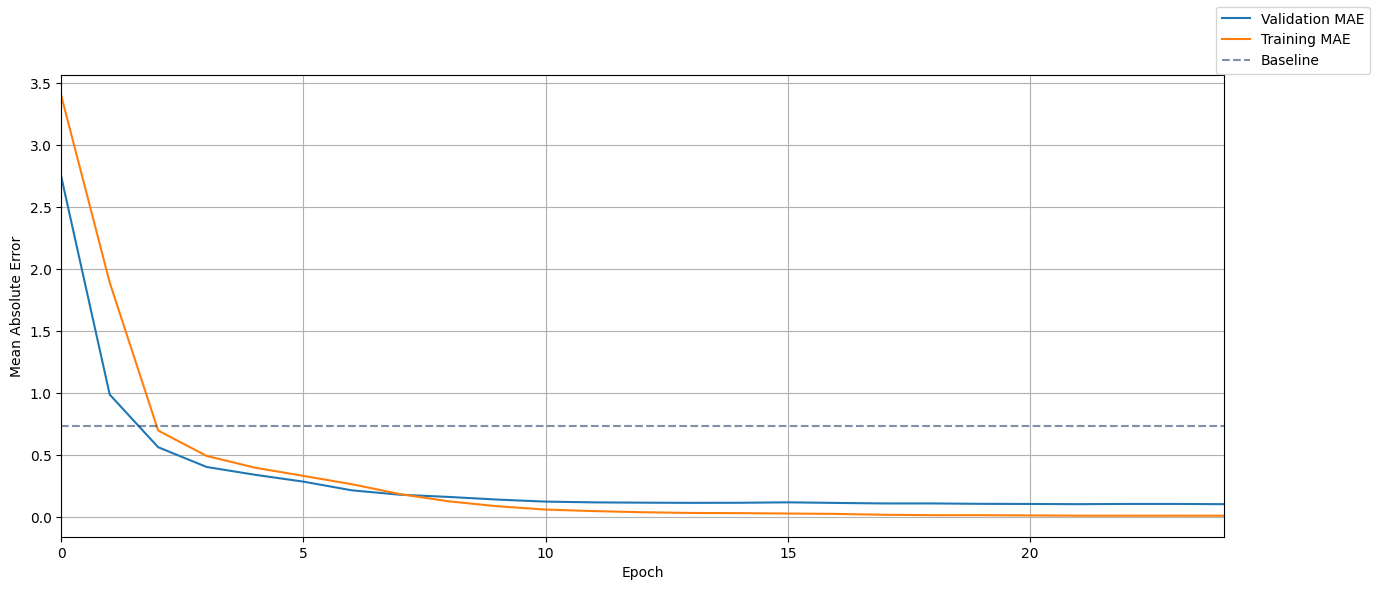

In [20]:
import matplotlib.pyplot as plt

# Step 5: Visualize training and validation MAE
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73  # Baseline MAE (replace with the actual baseline you calculated)
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=0.5)
ax.grid()
fig.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
R² score for validation set: 0.8503657107147676


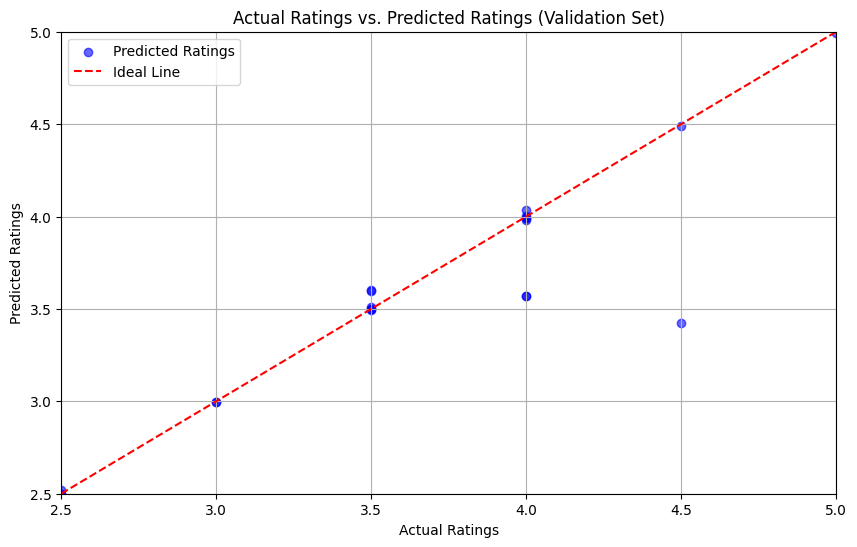

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


# Predict ratings for the validation set
y_val_pred = (model.predict([X_val_keywords_padded,X_val_genres_padded,X_val_avg_rating]))

# Calculate R² score for validation
r2_val = r2_score(y_val_rating, y_val_pred)
print(f'R² score for validation set: {r2_val}')

# Create the scatter plot for validation data
plt.figure(figsize=(10, 6))
plt.scatter(y_val_rating, y_val_pred, color='blue', alpha=0.6, label='Predicted Ratings')
plt.plot([y_val_rating.min(), y_val_rating.max()], 
         [y_val_rating.min(), y_val_rating.max()], 
         color='red', linestyle='--', label='Ideal Line')  # Ideal line
plt.title('Actual Ratings vs. Predicted Ratings (Validation Set)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.xlim(y_val_rating.min(), y_val_rating.max())
plt.ylim(y_val_rating.min(), y_val_rating.max())
plt.grid()
plt.legend()  
plt.show()


In [22]:
import pandas as pd

# Flatten y_val_pred to make it 1-dimensional
y_val_pred_flat = y_val_pred.ravel()  # or y_val_pred[:, 0]

# Create a DataFrame with actual and predicted ratings side by side
df_results = pd.DataFrame({
    'Actual Rating': y_val_rating,
    'Predicted Rating': y_val_pred_flat  # Use the flattened array
})

# Display rowss with significat error in prediction
high_diff=df_results[abs(df_results["Actual Rating"]-df_results["Predicted Rating"])>0.5]


(df_val.reset_index(drop=True)
 .merge(high_diff,left_index=True,right_index=True)
 [["Name","Actual Rating","Predicted Rating"]])

,Name,Actual Rating,Predicted Rating
13,Dune,4.5,3.426325


Our neural net says i shouldnt have liked Dune as much as i did. But Denis Villenueve outclassed our model, lol!

In [24]:
# Step 6: Save the model
model.save('main_model.keras')

# # Step 7: Load the model
# from keras.models import load_model
# loaded_model = load_model('movie_rating_model.h5')


In [25]:
model.save_weights('main_model.weights.h5')


In [45]:
import numpy as np
from keras_preprocessing.sequence import pad_sequences

# Function to encode the inputs and prepare for the model
def prepare_input(keywords, genres, avg_rating, 
                  max_keywords_length, max_genres_length, 
                  keyword_encoder, genre_encoder):
    
    # Encode keywords with handling for unseen labels
    encoded_keywords = []
    for kw in keywords:
        try:
            encoded_keywords.append(keyword_encoder.transform([kw])[0])  # Transform each keyword
        except ValueError:
            encoded_keywords.append(-1)  # Assign -1 or a default value for unseen labels
    
    # Pad the keywords to the max length
    padded_keywords = pad_sequences([encoded_keywords], maxlen=max_keywords_length, padding='post')

    # Encode genres with handling for unseen labels
    encoded_genres = []
    for genre in genres:
        try:
            encoded_genres.append(genre_encoder.transform([genre])[0])  # Transform each genre
        except ValueError:
            encoded_genres.append(-1)  # Assign -1 or a default value for unseen labels
    
    # Pad the genres to the max length
    padded_genres = pad_sequences([encoded_genres], maxlen=max_genres_length, padding='post')

    # Convert average_rating into a numpy array (since it's a numerical value)
    avg_rating_input = np.array([[float(avg_rating)]])
    return padded_keywords, padded_genres, avg_rating_input

# Example Input
keywords = ["suicide", "suicide attempt", "professor", "college", "middle class", "slapstick comedy", "friends", "engineering", "teacher", "coming of age", "university", "subjective camera", "smart kid", "poor kid", "brilliant", "student", "pregnant", "delhi"]
genres = ["Drama", "Comedy"]  # Example genres
avg_rating = 8  # Example average rating

# Example max lengths for padded sequences
max_keywords_length = 20  # Replace with your max length used during training
max_genres_length = 3      # Max number of genres to consider

# Prepare the inputs
padded_keywords, padded_genres, avg_rating_input = prepare_input(
    keywords, genres, avg_rating, 
    max_keywords_length, max_genres_length, 
    keyword_encoder=le_keywords, genre_encoder=le_genres
)



In [46]:
# Make the prediction
predicted_rating = model.predict([padded_keywords, padded_genres, avg_rating_input])

# Print the predicted rating
print(f"Predicted rating for this movie:\n {np.round(predicted_rating[0][0] * 2) / 2:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted rating for this movie:
 4.50
